# Grouping Single Cells!

Scientists use gene expression data to learn more about cell and tissue types. In this activity you have been given expression data for different types of blood cells. However we dont know what blood cells are in the sample!!!
We will use python to:
- Find out what cells are in the sample
- Find out how the cells are similar to each other

In [1]:
#libraries
#Do you remember why libraries are useful??
import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5


In [2]:
#read data
#this code reads in a big table of data which contains information on how much of each gene is expressed per cell
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

... writing an h5ad cache file to speedup reading next time


In [3]:
#lets look at the data
#type the name of your data to get info on it!!
#columnsxrows
#how many columns
#how many rows
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

Now we have read our data in what should we do next?
Why?

We want to remove genes that don't have a lot of expression because they might may the results unreliable!!
What would we call these cells?

In the next block set genes to 200 and cells to 3.
How many genes were removed?

In [4]:
#quality control
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [5]:
#very detailed QC
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/srv/conda/envs/notebook/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:07)


## Grouping Cells
We group cells together to see which ones are most similar to each other. You will see three graphs with each one using a different gene to look at differences. Which do you think is the best i.e. Which shows the most separate/distinct groups??

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:12)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


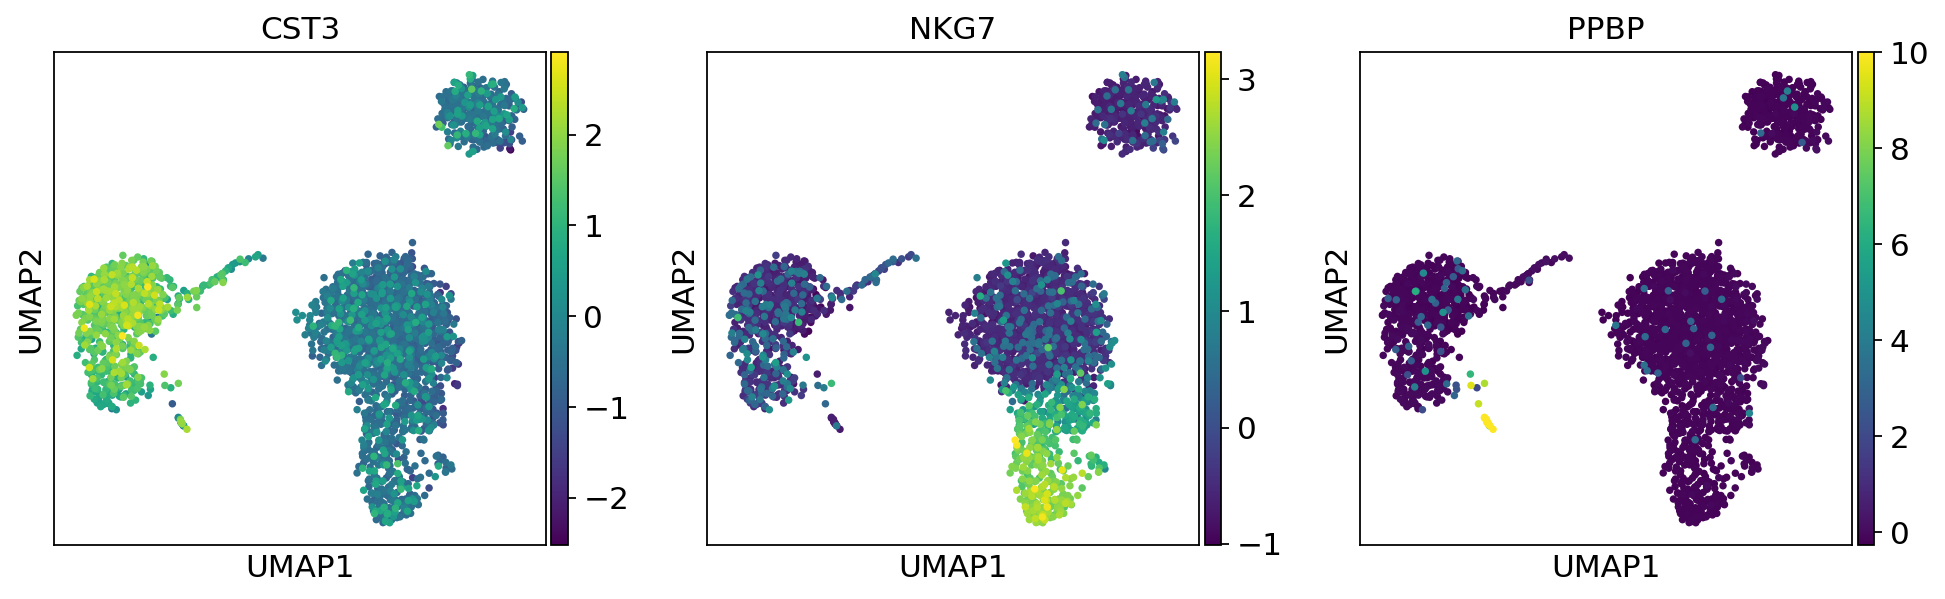

In [6]:
#group cells and plot
#Grouping the cells
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])


- We just grouped the cells together using expression. 
- Each cluster represents different groups of cells. 
- How many do you see?
- 3/4
- Next we will group using another method, leiden. 
- Replace the word newmethod with leiden
- Is there much difference in groups how many groups can you see now??
- 8

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


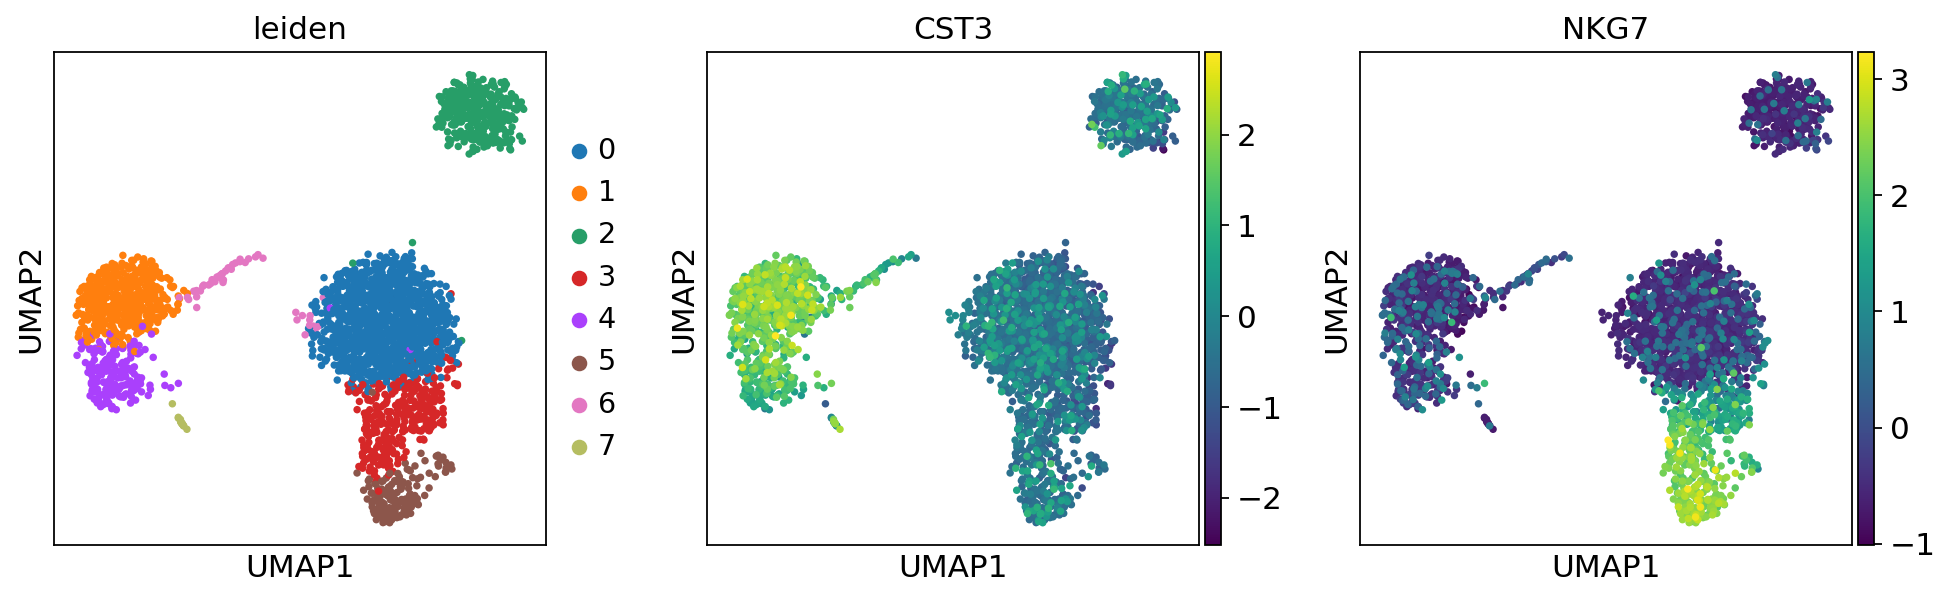

In [7]:
#fill in the blanks
sc.tl.leiden(adata)
#compare to old graph
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

- We can see that there are three main groups.  
- Blood cells have many subgroups but the main ones are:
     1. red cells
     2. white cells
     3. platelets
- These groups are then broken up into different types of cells which you can see in the picture below.
<div>
<img src="blood2.png" width="400">
</div>

## Identifying cells
- We want to see which subtypes of the groups above are in our data.
- Which subtypes do you think we will see?

- A scientist looked at the different genes that were present in the groups you found above. 
- They think that the gene expression means that the groups 8 groups match the cell types in the table below


 Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
5 | GNLY, NKG7	 | NK Cells
6 | FCER1A, CST3 |	Platelets
7 | PPBP |	Megakaryocytes

In [8]:
##make a list of the new names!!
new_cluster_names = ["CD4","CD14","B Cells","CD8","F Mono","Nk","Platelets","Mega"]
##add new names
adata.rename_categories('leiden', new_cluster_names)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


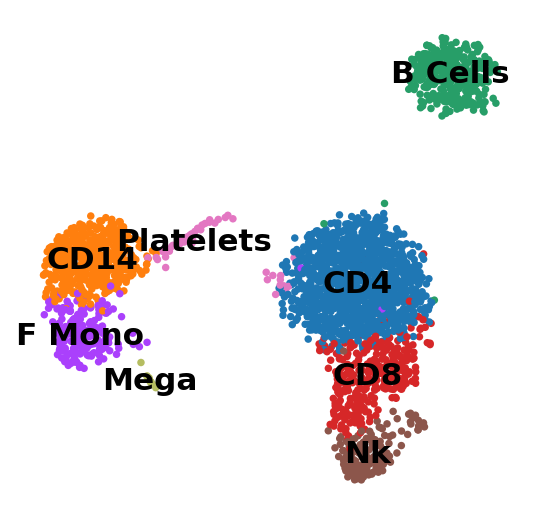

In [9]:
#lets look at the graph with identified cell types
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

## Discussion

- How many subtypes are there? 
- 8
- How many main groups are there?
- 3
- Does the picture above that shows the cell types match the groupings in our experiment???
- Yes
- Why are we interested in single cells??